<a href="https://colab.research.google.com/github/Leos1999/MarketTrendAnalyser/blob/master/Intraday.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [ ]:
sheet_url = 'https://docs.google.com/spreadsheets/d/1ao05clfZL1f2D8qtkYPTnAuNnbONSFr_pLVQJ8MkzHo/edit#gid=0'
csv_export_url = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')

In [ ]:
prices = pd.read_csv(csv_export_url)
prices.head()

,Date,Open,High,Low,Close,Volume,Date.1,Open.1
0,1/3/2005 15:30:00,166.93,169.59,166.93,169.16,591771,1/4/2005 15:30:00,168.75
1,1/4/2005 15:30:00,168.75,169.25,166.65,167.66,622388,1/5/2005 15:30:00,167.53
2,1/5/2005 15:30:00,167.53,167.53,160.04,165.63,1200540,1/6/2005 15:30:00,165.00
3,1/6/2005 15:30:00,165.00,168.25,161.56,165.06,1000861,1/7/2005 15:30:00,166.25
4,1/7/2005 15:30:00,166.25,168.13,164.08,167.49,952892,1/10/2005 15:30:00,168.58


In [ ]:
data = prices.drop(['Date','Date.1'],axis=1)
# data = prices.drop('Date.1',axis=1)
X_normalizer = MinMaxScaler(feature_range = (0,1))
y_normalizer = MinMaxScaler(feature_range = (0,1))
data.head()

,Open,High,Low,Close,Volume,Open.1
0,166.93,169.59,166.93,169.16,591771,168.75
1,168.75,169.25,166.65,167.66,622388,167.53
2,167.53,167.53,160.04,165.63,1200540,165.00
3,165.00,168.25,161.56,165.06,1000861,166.25
4,166.25,168.13,164.08,167.49,952892,168.58


In [ ]:
def preprocessor(X,y,window=4,test=False):
  if test:
    X_norm = X_normalizer.transform(X)
    y = y.reshape(-1,1)
    y_norm = y_normalizer.transform(y)
  else:
    X_norm = X_normalizer.fit_transform(X)
    y = y.reshape(-1,1)
    y_norm = y_normalizer.fit_transform(y)
  pre_X = []
  pre_y = []
  for i in range(window,len(y)):
    pre_X.append(X_norm[i-window:i,:])
    pre_y.append(y_norm[i,0])
  pre_X = np.array(pre_X)
  pre_y = np.array(pre_y)
  return pre_X,pre_y

def data_shuffler(pre_X,pre_y,split_size=0.85):
  concat = np.c_[pre_X.reshape(len(pre_X), -1), pre_y.reshape(len(pre_y), -1)]
  np.random.shuffle(concat)
  shuf_X = concat[:, :pre_X.size//len(pre_X)].reshape(pre_X.shape)
  shuf_y = concat[:, pre_X.size//len(pre_X):].reshape(pre_y.shape)
  train_size = int(split_size * len(pre_X))
  train_X = shuf_X[0:train_size]
  train_y = shuf_y[0:train_size]
  test_X = shuf_X[train_size:]
  test_y = shuf_y[train_size:]
  return train_X,train_y,test_X,test_y

In [ ]:
def step_decay(epoch):
  initial_lrate = 0.01
  drop = 0.3
  epochs_drop = 5.0
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lrate
def model_build(train_X,train_y,test_X,test_y,learning_rate=0.001,epochs=50,batch_size=1,name="new",comp="any"):
  model = Sequential()
  model.add(LSTM(units = 8,return_sequences=True,input_shape = (train_X.shape[1],train_X.shape[2])))
  model.add(LSTM(units = 4))
  model.add(Dense(units=1,activation='linear'))

  ckpt_model = 'model_'+comp+'_'+name+'.hdf5'
  checkpoint = ModelCheckpoint(ckpt_model,monitor='val_loss',verbose=1,
                               save_best_only=True,mode='min')
  lrate = learning_rate
  lrate = LearningRateScheduler(step_decay)
  callbacks_list = [checkpoint,lrate]
  optim = optimizers.Adam(learning_rate=learning_rate)
  model.compile(optimizer=optim,loss = 'mean_squared_error',metrics = ['mean_absolute_error'])

  history = model.fit(train_X,train_y,epochs=epochs,batch_size=batch_size,callbacks=callbacks_list,validation_data=(test_X,test_y))
  return history,model,ckpt_model

In [ ]:
def predictor(model,X,y):
  y_predict = model.predict(X)
  y_predict = y_normalizer.inverse_transform(y_predict)
  y_actual = y_normalizer.inverse_transform(y.reshape(-1,1))
  plt.figure(figsize=(16,12))
  print(y_actual.shape,y_predict.shape)
  plt.plot(y_predict, color = 'red',label = "Predicted")
  plt.plot(y_actual, color = 'blue',label = "Actual")
  plt.xlabel('Days')
  plt.ylabel('Price')
  plt.legend()
  return y_actual,y_predict

In [ ]:
X = data.iloc[:-10,[1,2,3,4]].values
y = data.iloc[:-10,0].values
pre_X,pre_y = preprocessor(X,y,4)
train_X,train_y,test_X,test_y = data_shuffler(pre_X,pre_y,0.85)
history,model,model2 = model_build(train_X,train_y,test_X,test_y,learning_rate=0.001,epochs=50,batch_size=1,name='open',comp='TCS')

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# Predicting next 10 days
model_ = load_model("/content/model_TCS_open.hdf5")
_X,_y = preprocessor(data.iloc[-11:,[1,2,3,4]].values,data.iloc[-11:,0].values,4,test=True)
org,pred = predictor(model_,_X,_y)

In [ ]:
win = 0
loss = 0
for i in range(1,len(org)):
  if pred[i] > pred[i-1] and org[i] > org[i-1]:
    win += 1
  elif pred[i] < pred[i-1] and org[i] < org[i-1]:
    win += 1
  else:
    loss+=1
print(win,loss)
print("Trend prediction success probablity:",((win/(win+loss))*100))
print("Trend prediction loss probablity:",((loss/(win+loss))*100))

In [ ]:
_X = data.iloc[-4:,[1,2,3,4]].values
_y = data.iloc[-1,0]
X_norm = X_normalizer.transform(_X)
pre_X = []
pre_y = []
pre_X.append(X_norm[0:4,:])
pre_X = np.array(pre_X)
y_predict = model_.predict(pre_X)
y_predict = y_normalizer.inverse_transform(y_predict)
print("Next day's open:",y_predict)
if y_predict > _y:
  print("Open has up-trend")
elif y_predict < _y:
  print("Open has down-trend")
else:
  print("Open has no clear trend")

Next day's open: [[2087.9185]]
Open has down-trend


Close

In [ ]:
X = data.iloc[:-10,[0,1,2,4,5]].values
y = data.iloc[:-10,3].values
pre_X,pre_y = preprocessor(X,y,4)
train_X,train_y,test_X,test_y = data_shuffler(pre_X,pre_y,0.85)
history,model,model2 = model_build(train_X,train_y,test_X,test_y,learning_rate=0.001,epochs=50,batch_size=1,name='close',comp='TCS')

Epoch 1/50
3230/3230 [==============================] - ETA: 0s - loss: 0.0013 - mean_absolute_error: 0.0234
Epoch 00001: val_loss improved from inf to 0.00075, saving model to model_TCS_close.hdf5
3230/3230 [==============================] - 13s 4ms/step - loss: 0.0013 - mean_absolute_error: 0.0234 - val_loss: 7.4616e-04 - val_mean_absolute_error: 0.0221 - lr: 0.0100
Epoch 2/50
3217/3230 [============================>.] - ETA: 0s - loss: 7.5779e-04 - mean_absolute_error: 0.0189
Epoch 00002: val_loss did not improve from 0.00075
3230/3230 [==============================] - 11s 4ms/step - loss: 7.5861e-04 - mean_absolute_error: 0.0189 - val_loss: 8.9776e-04 - val_mean_absolute_error: 0.0243 - lr: 0.0100
Epoch 3/50
3221/3230 [============================>.] - ETA: 0s - loss: 5.2196e-04 - mean_absolute_error: 0.0159
Epoch 00003: val_loss did not improve from 0.00075
3230/3230 [==============================] - 11s 4ms/step - loss: 5.2586e-04 - mean_absolute_error: 0.0159 - val_loss: 8.822

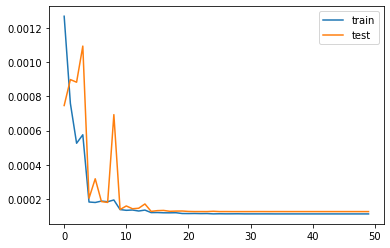

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

(8, 1) (8, 1)


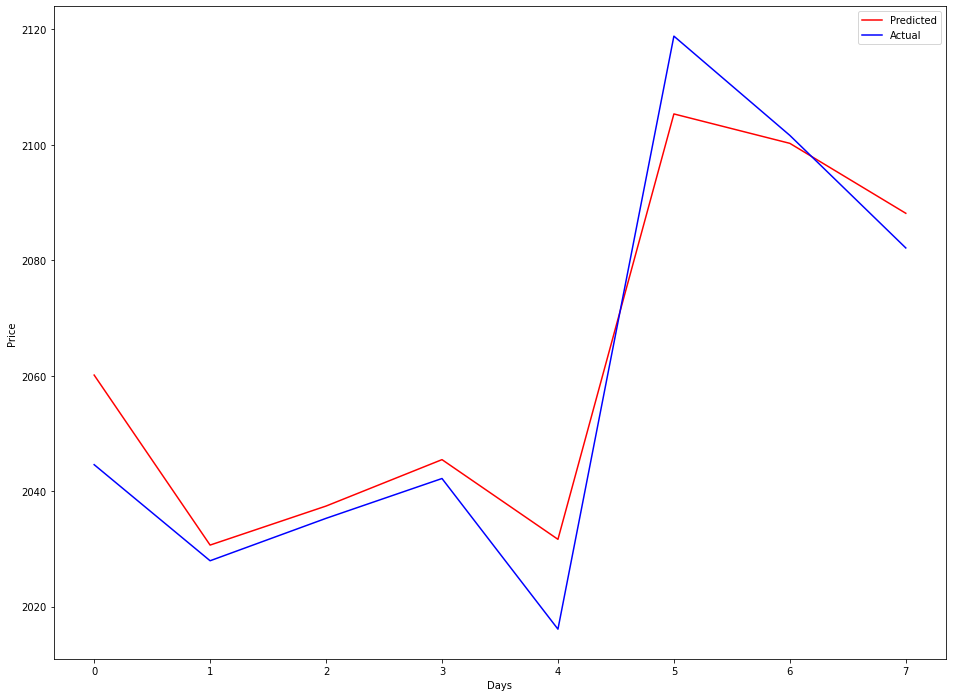

In [ ]:
# Predicting next 10 days
model_ = load_model("/content/model_TCS_close.hdf5")
_X,_y = preprocessor(data.iloc[-11:,[0,1,2,4,5]].values,data.iloc[-11:,3].values,4,test=True)
org,pred = predictor(model_,_X,_y)

In [ ]:
win = 0
loss = 0
for i in range(1,len(org)):
  if pred[i] > pred[i-1] and org[i] > org[i-1]:
    win += 1
  elif pred[i] < pred[i-1] and org[i] < org[i-1]:
    win += 1
  else:
    loss+=1
print(win,loss)
print("Trend prediction success probablity:",((win/(win+loss))*100))
print("Trend prediction loss probablity:",((loss/(win+loss))*100))

2 3
Trend prediction success probablity: 40.0
Trend prediction loss probablity: 60.0


In [ ]:
_X = data.iloc[-4:,[0,1,2,4,5]].values
_y = data.iloc[-1,3]
X_norm = X_normalizer.transform(_X)
pre_X = []
pre_y = []
pre_X.append(X_norm[0:4,:])
pre_X = np.array(pre_X)
y_predict = model_.predict(pre_X)
y_predict = y_normalizer.inverse_transform(y_predict)
print("Next day's open:",y_predict)
if y_predict > _y:
  print("Open has up-trend")
elif y_predict < _y:
  print("Open has down-trend")
else:
  print("Open has no clear trend")

Next day's open: [[2103.038]]
Open has up-trend


In [ ]:
train.isnull().sum()/len(train)*100
train.var()
df.corr()